In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt

In [2]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
# file2 = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231214Z.h5"

f = h5py.File(path+file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

In [3]:
sliced_data = data[7500:12500,:]
lp_dat = obsfilt.lowpass(sliced_data.T, 8, 200, corners=1)#, zerophase=True)
lp_spat_dat = obsfilt.lowpass(sliced_data, 0.04, 0.5, corners=4)

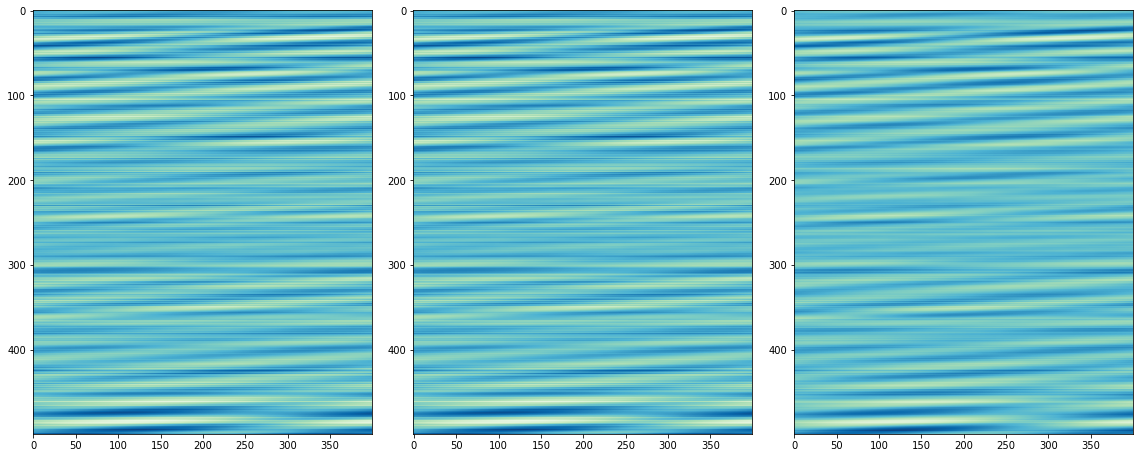

In [4]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (16,10))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()

vmin=-16478396

vmax = 12709804

im = ax1.imshow((data[7500:12500:10,:4000:10]), vmin=vmin, vmax=vmax,
                cmap = 'GnBu')

im2 = ax2.imshow((lp_spat_dat[::10,:4000:10]), vmin=vmin, vmax=vmax,
                cmap = 'GnBu')

im2 = ax3.imshow((lp_dat.T[::10,:4000:10]), vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
# plt.xlabel("Time", fontsize = 15)
# plt.ylabel("Channel", fontsize = 15)

# plt.colorbar(im, ax = ax2, pad = 0.04)
plt.show()

In [7]:
n = 1.4682
L = 51.04762
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*lp_dat
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
print(working_dat.shape)

(12000, 5000, 1)


In [8]:
dx=2.0419047
dt=1/200.
ut = ps.FiniteDifference(d=1, axis=0,order=4,is_uniform=True,
                         drop_endpoints=False)._differentiate(working_dat, dt)
ux = ps.FiniteDifference(d=1, axis=1,order=4,is_uniform=True,
                         drop_endpoints=False)._differentiate(working_dat, dx)
# uxx = ps.FiniteDifference(d=2, axis=1,order=4,is_uniform=True,
#                           drop_endpoints=False)._differentiate(working_dat, dx)
# uxxx = ps.FiniteDifference(d=3, axis=1,order=4,is_uniform=True,
#                            drop_endpoints=False)._differentiate(working_dat, dx)
# uxxxx = ps.FiniteDifference(d=4, axis=0,
#                             drop_endpoints=False)._differentiate(u, dx)

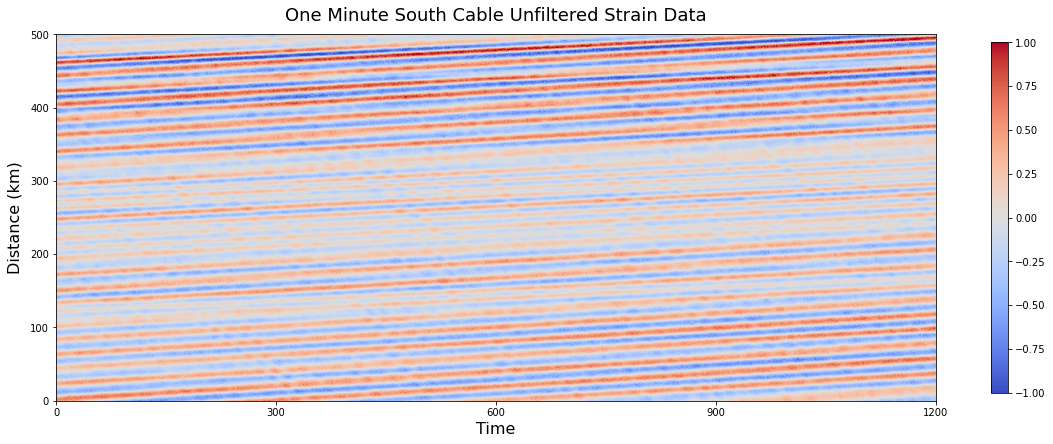

In [9]:
fig, ax = plt.subplots(figsize = (16, 6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((ut[::10,::10,0].T),vmin=-1, vmax=1,
               extent = [0,1200,  0,500],
               cmap = 'coolwarm')

ax.set_xlabel("Time",size=16)
ax.set_ylabel("Distance (km)",size=16, labelpad = 8)#, fontsize = 16)


jump_val = 500

ax.set_xticks(np.linspace(0,1200, 5))#,np.linspace(0,12000, 5)/10000)
# ax.xaxis_date()
# date_format = mdates.DateFormatter('%d-%b\n%H:%M:%S.%f')
# ax.xaxis.set_major_formatter(date_format)
# ax.set_xticklabels([x.strftime('%d-%b\n%H:%M:%S.%f') for x in mdates.num2date(np.linspace(toas[0], toas[1], 5))])
# plt.xticks(rotation=15)

# plt.yticks(np.arange(y_lims[0], y_lims[1]+jump_val, jump_val),
#            np.round((2/1000)*np.arange(y_lims[0], y_lims[1]+jump_val, jump_val)))

ax.set_title("One Minute South Cable Unfiltered Strain Data",fontsize=18,y=1.02)#file.split('.')[0])
plt.colorbar(im, ax = ax, pad = 0.05,shrink=0.9)
plt.show()

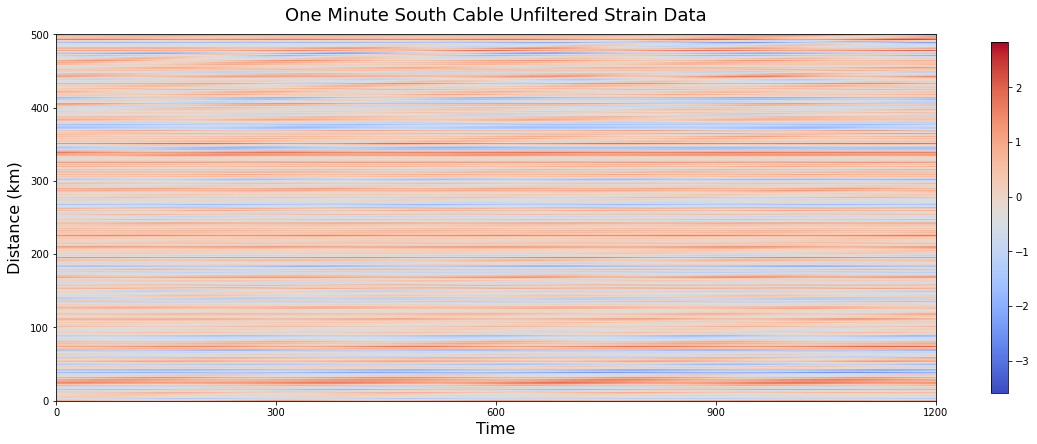

In [16]:
# output = ((-15.534*ux[:12000:10,::10,0])  -(19.324*uxxx[:12000:10,::10,0]) - (3.325* working_dat[:12000:10,::10,0]*uxx[:12000:10,::10,0])).T
# output=((5.559* ux[:12000:10,::10,0]) +( 20.621* uxxx[:12000:10,::10,0])).T
fig, ax = plt.subplots(figsize = (16, 6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((15*ux[::10,::10,0].T),#vmin=-1, vmax=1,
               extent = [0,1200,  0,500],
               cmap = 'coolwarm')

ax.set_xlabel("Time",size=16)
ax.set_ylabel("Distance (km)",size=16, labelpad = 8)#, fontsize = 16)


jump_val = 500

ax.set_xticks(np.linspace(0,1200, 5))#,np.linspace(0,12000, 5)/10000)
# ax.xaxis_date()
# date_format = mdates.DateFormatter('%d-%b\n%H:%M:%S.%f')
# ax.xaxis.set_major_formatter(date_format)
# ax.set_xticklabels([x.strftime('%d-%b\n%H:%M:%S.%f') for x in mdates.num2date(np.linspace(toas[0], toas[1], 5))])
# plt.xticks(rotation=15)

# plt.yticks(np.arange(y_lims[0], y_lims[1]+jump_val, jump_val),
#            np.round((2/1000)*np.arange(y_lims[0], y_lims[1]+jump_val, jump_val)))

ax.set_title("One Minute South Cable Unfiltered Strain Data",fontsize=18,y=1.02)#file.split('.')[0])
plt.colorbar(im, ax = ax, pad = 0.05,shrink=0.9)
plt.show()

## SINDy

In [71]:
working_dat = lp_dat #[::10,::10]
working_dat = working_dat/(np.std(working_dat))

In [72]:
print(np.amax(working_dat))
print(np.amin(working_dat))

3.909200135384178
-4.091795464169305


In [73]:
2e-1

0.2

In [74]:
working_dat = working_dat.reshape(working_dat.shape[1],working_dat.shape[0],1)
dt=1/200
x = 2*np.arange(working_dat.shape[1])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
    periodic=True
)

In [75]:
# dt=1.
# x = np.arange(working_dat.shape[1])

optimizer = ps.STLSQ(threshold=4.8, alpha=1e-5, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

print("Ensemble STLSQ")
model.print()

Ensemble STLSQ
(x0)' = 593.586 x0_1 + 112.750 x0_11 + 1187.523 x0_111 + 112.632 x0_1111 + -9.103 x0x0_1 + -14.400 x0x0x0_1 + -18.136 x0x0_11 + -14.414 x0x0x0_11 + -60.597 x0x0_111 + -56.314 x0x0x0_111 + -121.486 x0x0_1111 + -56.201 x0x0x0_1111
